# Example 12 - Using different DOE methods for PFR yield optimization

In this notebook, we will compare the outcomes for PFR yield optimization using different DOE methods. By comparing to Example 5, additional DOE methods including Box-Behnken design, Central-Composite design, and Sobol sequence.

Note: this notebook requires ax and pyDOE2 to be install first. See instructions on the [Ax](https://ax.dev/) and [PyDOE2](https://github.com/clicumu/pyDOE2) documentation page. 

## 1. Import packages

In [44]:
import numpy as np
import time
from IPython.display import display
import pprint
import pyDOE2 as DOE

pp = pprint.PrettyPrinter(indent=4)

from ax import *
from ax.modelbridge.registry import Models
from ax.modelbridge.factory import get_sobol
from nextorch import plotting, bo, doe, utils, io


## 2. Define the objective function and the design space

In [20]:
#%% Define the objective function
from fructose_pfr_model_function import Reactor

def PFR_yield(X_real):
    """PFR model

    Parameters
    ----------
    X_real : numpy matrix
        reactor parameters: 
        T, pH and tf in real scales

    Returns
    -------
    Y_real: numpy matrix
        reactor yield 
    """
    if len(X_real.shape) < 2:
        X_real = np.expand_dims(X_real, axis=1) #If 1D, make it 2D array
        
    Y_real = []
    for i, xi in enumerate(X_real):
        Conditions = {'T_degC (C)': xi[0], 'pH': xi[1], 'tf (min)' : 10**xi[2]}
        yi, _ = Reactor(**Conditions) # only keep the first output       
        Y_real.append(yi)
            
    Y_real = np.array(Y_real)
    # Put y in a column
    Y_real = np.expand_dims(Y_real, axis=1)
        
    return Y_real # yield

# Objective function
objective_func = PFR_yield


#%% Define the design space
# Three input temperature C, pH, log10(residence time)
X_name_list = ['T', 'pH', r'$\rm log_{10}(tf_{min})$']
X_units = [r'$\rm ^{o}C $', '', '']

# Add the units
X_name_with_unit = []
for i, var in enumerate(X_name_list):
    if not X_units[i]  == '':
        var = var + ' ('+ X_units[i] + ')'
    X_name_with_unit.append(var)
    
# One output
Y_name_with_unit = 'Yield %'

# combine X and Y names
var_names = X_name_with_unit + [Y_name_with_unit]

# Set the operating range for each parameter
X_ranges =  [[140, 200], # Temperature ranges from 140-200 degree C
             [0, 1], # pH values ranges from 0-1 
             [-2, 2]] # log10(residence time) ranges from -2-2  

# Set the reponse range
Y_plot_range = [0, 50]

# Get the information of the design space
n_dim = len(X_name_list) # the dimension of inputs
n_objective = 1 # the dimension of outputs

## 3. Define the initial sampling plan
Here we compare 6 sampling plans with the same number of sampling points:

1. Full factorial (FF) design with levels of 4 and 64 points in total. 
2. Latin hypercube (LHC) design with 10 initial sampling points, and 54 more Bayesian Optimization trials
3. Completely random (RND) samping with 64 points
4. Box-Behnken design (BB)
5. Central-Composite design (CC)
6. Sobol sequence (Sobol)

The initial reponse in a real scale `Y_init_real` is computed from the helper function `bo.eval_objective_func(X_init, X_ranges, objective_func)`, given `X_init` in unit scales. It might throw warning messages since the model solves some edge cases of ODEs given certain input combinations. 

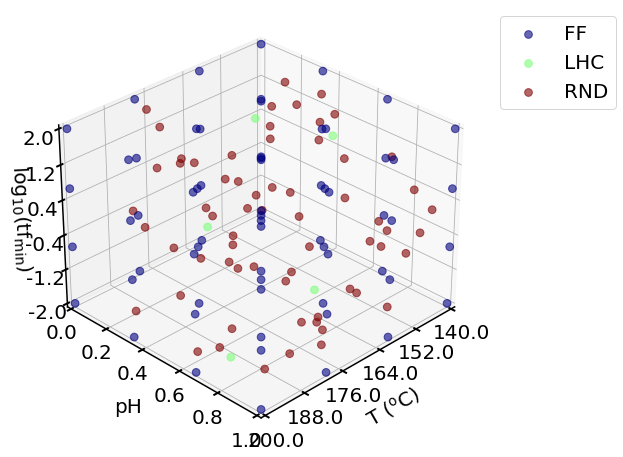

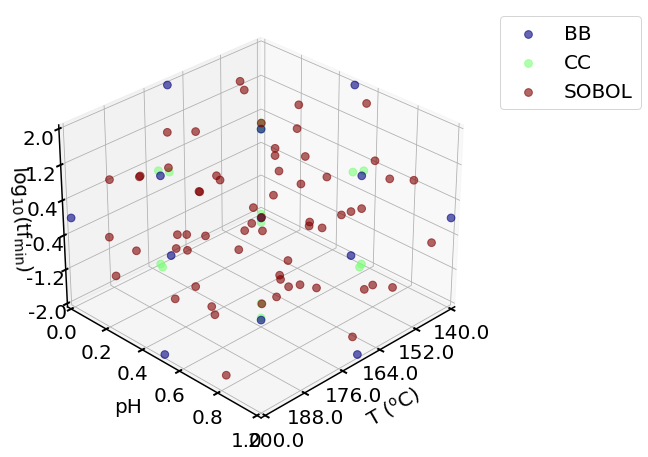

In [50]:
#%% Initial Sampling 
# Full factorial design 
n_ff_level = 4
n_total = n_ff_level**n_dim

X_ff = doe.full_factorial([n_ff_level, n_ff_level, n_ff_level])
# Get the initial responses
Y_ff = bo.eval_objective_func(X_ff, X_ranges, objective_func)

# Latin hypercube design with 10 initial points
n_init_lhc = 5
X_init_lhc = doe.latin_hypercube(n_dim = n_dim, n_points = n_init_lhc, seed= 1)
# Get the initial responses
Y_init_lhc = bo.eval_objective_func(X_init_lhc, X_ranges, objective_func)

# Completely random design 
X_rnd = doe.randomized_design(n_dim=n_dim, n_points=n_total, seed=1)
# Get the responses
Y_rnd = bo.eval_objective_func(X_rnd, X_ranges, objective_func)

# Box-behnken design
X_bb_orig = DOE.bbdesign(3, center=1)
X_bb_ranges = [[-1, 1], [-1, 1], [-1, 1]] 
X_bb = utils.unitscale_X(X_bb_orig, X_ranges = X_bb_ranges)
Y_bb = bo.eval_objective_func(X_bb, X_ranges, objective_func)

# Central-composite design
X_cc_orig = DOE.ccdesign(3, center=(0, 1))
X_cc_ranges = [[-1.87082869, 1.87082869], [-1.87082869, 1.87082869], [-1.87082869, 1.87082869]]
X_cc = utils.unitscale_X(X_cc_orig, X_ranges = X_cc_ranges)
Y_cc = bo.eval_objective_func(X_cc, X_ranges, objective_func)

# Sobol sequence
range_param1 = RangeParameter(name="x1", lower=140.0, upper=200.0, parameter_type=ParameterType.FLOAT)
range_param2 = RangeParameter(name="x2", lower=0.0, upper=1.0, parameter_type=ParameterType.FLOAT)
range_param3 = RangeParameter(name="x3", lower=-2.0, upper=2.0, parameter_type=ParameterType.FLOAT)

search_space = SearchSpace(parameters=[range_param1, range_param2, range_param3],)
m = get_sobol(search_space)
gr = m.gen(n=64)

X_sobol_orig = gr.param_df.to_numpy()
X_sobol = utils.unitscale_X(X_sobol_orig, X_ranges = X_ranges)
Y_sobol = bo.eval_objective_func(X_sobol, X_ranges, objective_func)

# Compare the first 3 sampling plans
plotting.sampling_3d([X_ff, X_init_lhc, X_rnd], 
                     X_names = X_name_with_unit,
                     X_ranges = X_ranges,
                     design_names = ['FF', 'LHC', 'RND'])

# Compare the second 3 sampling plans
plotting.sampling_3d([X_bb, X_cc, X_sobol], 
                     X_names = X_name_with_unit,
                     X_ranges = X_ranges,
                     design_names = ['BB', 'CC', 'SOBOL'])

## 4. Initialize an `Experiment` object 

Next, we initialize 6 `Experiment` objects for FF, LHC, RND, BB, CC, SOBOL, respectively. We also set the objective function and the goal as maximization. 

We will train 6 GP models. Some progress status will be printed out.

In [51]:
#%% Initialize an Experiment object
# Set its name, the files will be saved under the folder with the same name
Exp_ff = bo.Experiment('PFR_yield_ff') 
# Import the initial data
Exp_ff.input_data(X_ff, Y_ff, X_ranges = X_ranges, unit_flag = True)
# Set the optimization specifications 
# here we set the objective function, minimization by default
Exp_ff.set_optim_specs(objective_func = objective_func, 
                        maximize =  True)


# Set its name, the files will be saved under the folder with the same name
Exp_lhc = bo.Experiment('PFR_yield_lhc') 
# Import the initial data
Exp_lhc.input_data(X_init_lhc, Y_init_lhc, X_ranges = X_ranges, unit_flag = True)
# Set the optimization specifications 
# here we set the objective function, minimization by default
Exp_lhc.set_optim_specs(objective_func = objective_func, 
                        maximize =  True)


# Set its name, the files will be saved under the folder with the same name
Exp_rnd = bo.Experiment('PFR_yield_rnd') 
# Import the initial data
Exp_rnd.input_data(X_rnd, Y_rnd, X_ranges = X_ranges, unit_flag = True)
# Set the optimization specifications 
# here we set the objective function, minimization by default
Exp_rnd.set_optim_specs(objective_func = objective_func, 
                        maximize =  True)

# Set its name, the files will be saved under the folder with the same name
Exp_bb = bo.Experiment('PFR_yield_bb') 
# Import the initial data
Exp_bb.input_data(X_bb, Y_bb, X_ranges = X_ranges, unit_flag = True)
# Set the optimization specifications 
# here we set the objective function, minimization by default
Exp_bb.set_optim_specs(objective_func = objective_func, 
                        maximize =  True)

# Set its name, the files will be saved under the folder with the same name
Exp_cc = bo.Experiment('PFR_yield_cc') 
# Import the initial data
Exp_cc.input_data(X_cc, Y_cc, X_ranges = X_ranges, unit_flag = True)
# Set the optimization specifications 
# here we set the objective function, minimization by default
Exp_cc.set_optim_specs(objective_func = objective_func, 
                        maximize =  True)

# Set its name, the files will be saved under the folder with the same name
Exp_sobol = bo.Experiment('PFR_yield_sobol') 
# Import the initial data
Exp_sobol.input_data(X_sobol, Y_sobol, X_ranges = X_ranges, unit_flag = True)
# Set the optimization specifications 
# here we set the objective function, minimization by default
Exp_sobol.set_optim_specs(objective_func = objective_func, 
                        maximize =  True)

Iter 10/100: 1.5686978101730347
Iter 20/100: 1.4323296546936035
Iter 30/100: 1.213491439819336
Iter 40/100: 0.786024272441864
Iter 50/100: 0.726165771484375
Iter 10/100: 2.865771770477295
Iter 20/100: 2.680220365524292
Iter 30/100: 2.622067928314209
Iter 40/100: 2.6000359058380127
Iter 50/100: 2.5935592651367188
Iter 10/100: 1.5580168962478638
Iter 20/100: 1.410680890083313
Iter 30/100: 1.1793935298919678
Iter 40/100: 0.8040165901184082
Iter 10/100: 2.066924810409546
Iter 20/100: 1.9635365009307861
Iter 30/100: 1.9155951738357544
Iter 40/100: 1.890392541885376
Iter 50/100: 1.8804062604904175
Iter 60/100: 1.879346251487732
Iter 70/100: 1.8787802457809448
Iter 80/100: 1.8779988288879395
Iter 10/100: 1.9895148277282715
Iter 20/100: 1.8984469175338745
Iter 30/100: 1.8459131717681885
Iter 40/100: 1.782608151435852
Iter 50/100: 1.7727668285369873
Iter 10/100: 1.5433120727539062
Iter 20/100: 1.3875823020935059
Iter 30/100: 1.1545119285583496
Iter 40/100: 0.8233293890953064
Iter 50/100: 0.7819

## 5. Run trials 
We perform additional Bayesian Optimization trials for the LHC design using the default acquisition function (Expected Improvement (EI)). 

In [52]:
#%% Optimization loop
# Set the number of iterations  
n_trials_lhc = n_total - n_init_lhc
for i in range(n_trials_lhc):
    # Generate the next experiment point
    X_new, X_new_real, acq_func = Exp_lhc.generate_next_point()
    # Get the reponse at this point
    Y_new_real = objective_func(X_new_real) 
    # or 
    # Y_new_real = bo.eval_objective_func(X_new, X_ranges, objective_func)

    # Retrain the model by input the next point into Exp object
    Exp_lhc.run_trial(X_new, X_new_real, Y_new_real)

Iter 10/100: 2.5517055988311768
Iter 10/100: 2.3440499305725098
Iter 20/100: 2.338698625564575
Iter 30/100: 2.338371753692627
Iter 10/100: 2.16644287109375
Iter 20/100: 2.1642606258392334
Iter 10/100: 1.9865648746490479
Iter 10/100: 1.8468053340911865
Iter 10/100: 1.719537377357483
Iter 10/100: 1.632025122642517
Iter 10/100: 1.531653881072998
Iter 10/100: 1.4744662046432495
Iter 10/100: 1.4254746437072754
Iter 10/100: 1.3304728269577026
Iter 10/100: 1.3641164302825928
Iter 10/100: 1.2657198905944824
Iter 10/100: 0.8373811841011047
Iter 20/100: 0.8372235894203186
Iter 10/100: 0.8571775555610657
Iter 10/100: 0.9100853800773621
Iter 20/100: 0.9100245237350464
Iter 30/100: 0.9099763035774231
Iter 10/100: 0.8621917366981506
Iter 10/100: 0.8654945492744446
Iter 10/100: 0.8895480036735535
Iter 10/100: 0.9354801774024963
Iter 20/100: 0.9344072937965393
Iter 30/100: 0.9339752197265625
Iter 10/100: 0.9116963148117065
Iter 10/100: 0.8916342258453369
Iter 10/100: 0.9162153601646423
Iter 10/100: 0.

/Users/tyc/opt/anaconda3/lib/python3.8/site-packages/scipy/integrate/_ode.py:1179: UserWarning:

dopri5: larger nsteps is needed



Iter 10/100: 0.47807568311691284
Iter 20/100: 0.4772675335407257
Iter 30/100: 0.47716668248176575
Iter 10/100: 0.4213515520095825
Iter 10/100: 0.3790358603000641
Iter 20/100: 0.3784794211387634
Iter 10/100: 0.35941505432128906
Iter 10/100: 0.3217295706272125
Iter 10/100: 0.2765084505081177
Iter 20/100: 0.2761758267879486
Iter 10/100: 0.26499268412590027
Iter 20/100: 0.2645130455493927
Iter 30/100: 0.2643025517463684
Iter 10/100: 0.28205999732017517
Iter 10/100: 0.22375275194644928
Iter 20/100: 0.22348293662071228
Iter 10/100: 0.23992861807346344
Iter 20/100: 0.23947708308696747
Iter 30/100: 0.23920564353466034
Iter 40/100: 0.2392088621854782
Iter 10/100: 0.24233517050743103
Iter 10/100: 0.2020682692527771
Iter 10/100: 0.18797343969345093
Iter 20/100: 0.18778184056282043
Iter 30/100: 0.18769574165344238
Iter 10/100: 0.13331356644630432
Iter 10/100: 0.08316085487604141
Iter 20/100: 0.08285044878721237
Iter 10/100: 0.039189744740724564
Iter 10/100: 0.00905551202595234
Iter 20/100: 0.00843

## 6. Visualize the final model reponses
We would like to see how sampling points scattered in the 3D space. A 2D slices of the 3D space is visualized below at a fixed x value . 

LHC sampling points


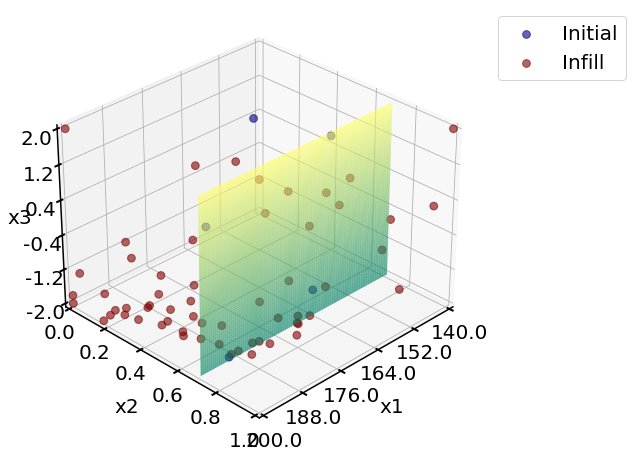

BB sampling points


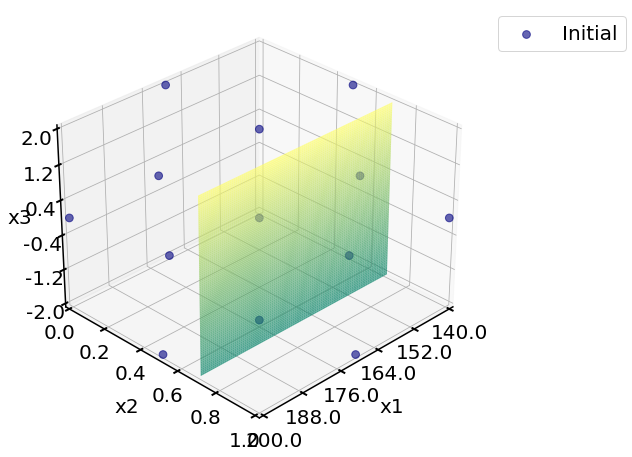

CC sampling points


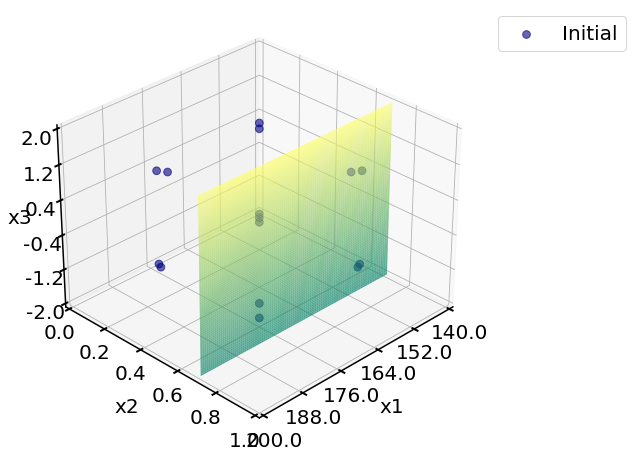

SOBOL sampling points


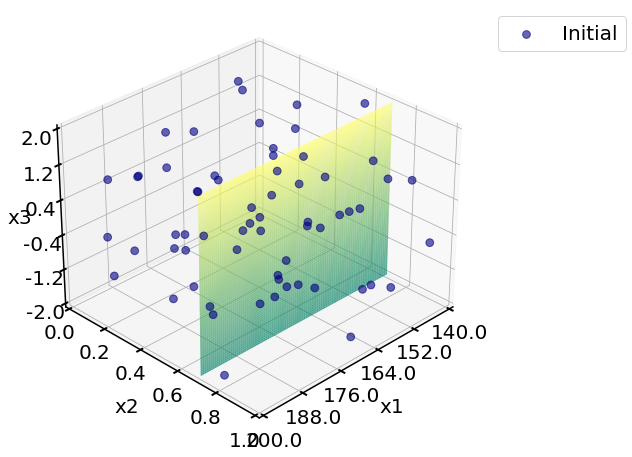

Comparing 4 plans: 


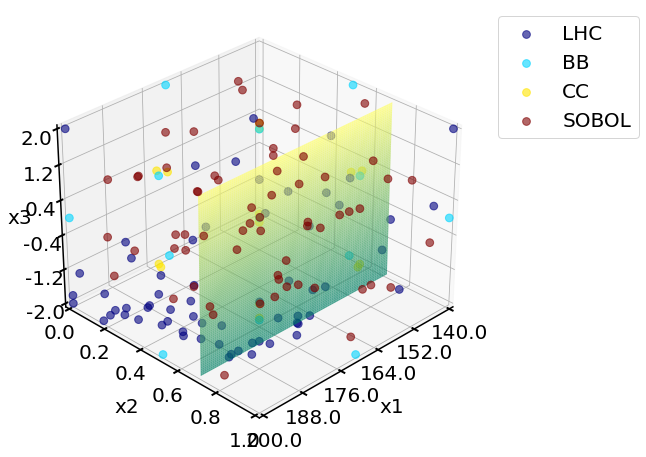

In [53]:
#%% plots 
# Check the sampling points
# Final lhc Sampling
x2_fixed_real = 0.7 # fixed x2 value
x_indices = [0, 2] # 0-indexing, for x1 and x3
print('LHC sampling points')
plotting.sampling_3d_exp(Exp_lhc, 
                         slice_axis = 'y', 
                         slice_value_real = x2_fixed_real)    

print('BB sampling points')
plotting.sampling_3d_exp(Exp_bb, 
                         slice_axis = 'y', 
                         slice_value_real = x2_fixed_real)    

print('CC sampling points')
plotting.sampling_3d_exp(Exp_cc, 
                         slice_axis = 'y', 
                         slice_value_real = x2_fixed_real)    

print('SOBOL sampling points')
plotting.sampling_3d_exp(Exp_sobol, 
                         slice_axis = 'y', 
                         slice_value_real = x2_fixed_real)    


# Compare 3 sampling plans
print('Comparing 4 plans: ')
plotting.sampling_3d([Exp_lhc.X, Exp_bb.X, Exp_cc.X, Exp_sobol.X], 
                     X_ranges = X_ranges,
                     design_names = ['LHC', 'BB', 'CC', 'SOBOL'],
                     slice_axis = 'y', 
                     slice_value_real = x2_fixed_real)

By fixing the value of pH (`x2`), we can plot the 2D reponse surfaces by varying T (`x1`) and tf (`x3`). It takes a long time to get the reponses from the objective function. 

To create a heatmap, we generate `mesh_size` (by default = 41, here we set it as 20) test points along one dimension. For a 2D mesh, 20 by 20, i.e. 400 times of evaluation is needed. The following code indicates that evaluting the GP surrogate model is much faster than calling the objective function. 

Objective function heatmap: 


/Users/tyc/opt/anaconda3/lib/python3.8/site-packages/scipy/integrate/_ode.py:1179: UserWarning:

dopri5: larger nsteps is needed



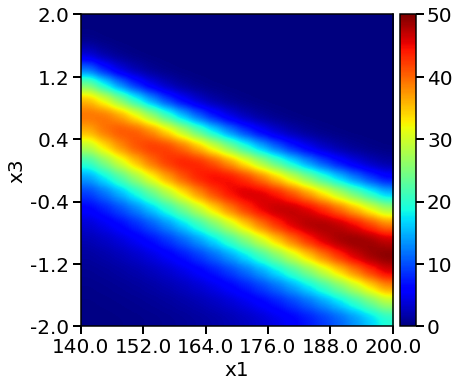

Evaluation of objective function 400 times takes 0.17 min

LHC model heatmap: 


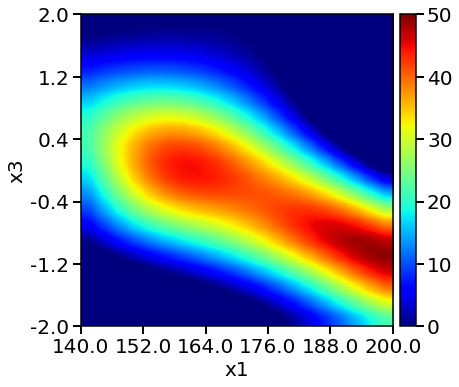

Evaluation of LHC GP model 400 times takes 0.00 min

BB model heatmap: 


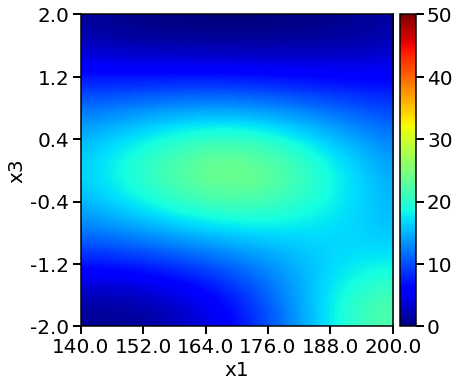

Evaluation of BB GP model 400 times takes 0.00 min

CC model heatmap: 


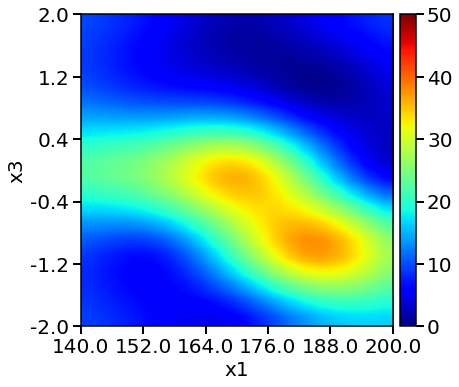

Evaluation of CC GP model 400 times takes 0.00 min

SOBOL model heatmap: 


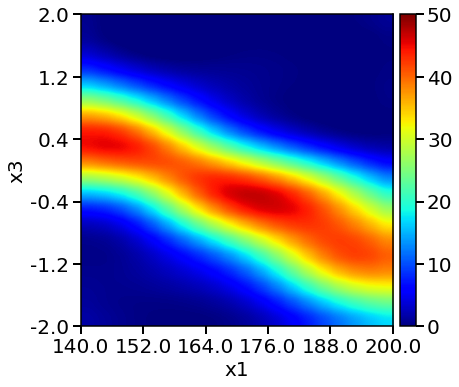

Evaluation of SOBOL GP model 400 times takes 0.00 min



In [54]:
# Reponse heatmaps
# Set X_test mesh size
mesh_size = 20
n_test = mesh_size**2

# Objective function heatmap
# (this takes a long time)
print('Objective function heatmap: ')
start_time = time.time()
plotting.objective_heatmap(objective_func, 
                          X_ranges, 
                          Y_real_range = Y_plot_range, 
                          x_indices = x_indices, 
                          fixed_values_real = x2_fixed_real,
                          mesh_size = mesh_size)
end_time = time.time()
print('Evaluation of objective function {} times takes {:.2f} min\n'.format(n_test, (end_time-start_time)/60))


# LHC heatmap 
print('LHC model heatmap: ')
start_time = time.time()
plotting.response_heatmap_exp(Exp_lhc, 
                              Y_real_range = Y_plot_range, 
                              x_indices = x_indices, 
                              fixed_values_real = x2_fixed_real,
                              mesh_size = mesh_size)
end_time = time.time()
print('Evaluation of LHC GP model {} times takes {:.2f} min\n'.format(n_test, (end_time-start_time)/60))


# Box-Behnken heatmap
print('BB model heatmap: ')
start_time = time.time()
plotting.response_heatmap_exp(Exp_bb, 
                              Y_real_range = Y_plot_range,
                              x_indices = x_indices, 
                              fixed_values_real = x2_fixed_real,
                              mesh_size = mesh_size)
end_time = time.time()
print('Evaluation of BB GP model {} times takes {:.2f} min\n'.format(n_test, (end_time-start_time)/60)) 


# central composite heatmap 
print('CC model heatmap: ')
start_time = time.time()
plotting.response_heatmap_exp(Exp_cc, 
                              Y_real_range = Y_plot_range, 
                              x_indices = x_indices, 
                              fixed_values_real = x2_fixed_real,
                              mesh_size = mesh_size)
end_time = time.time()
print('Evaluation of CC GP model {} times takes {:.2f} min\n'.format(n_test, (end_time-start_time)/60))

# Sobol heatmap 
print('SOBOL model heatmap: ')
start_time = time.time()
plotting.response_heatmap_exp(Exp_sobol, 
                              Y_real_range = Y_plot_range, 
                              x_indices = x_indices, 
                              fixed_values_real = x2_fixed_real,
                              mesh_size = mesh_size)
end_time = time.time()
print('Evaluation of SOBOL GP model {} times takes {:.2f} min\n'.format(n_test, (end_time-start_time)/60))

Objective function surface: 


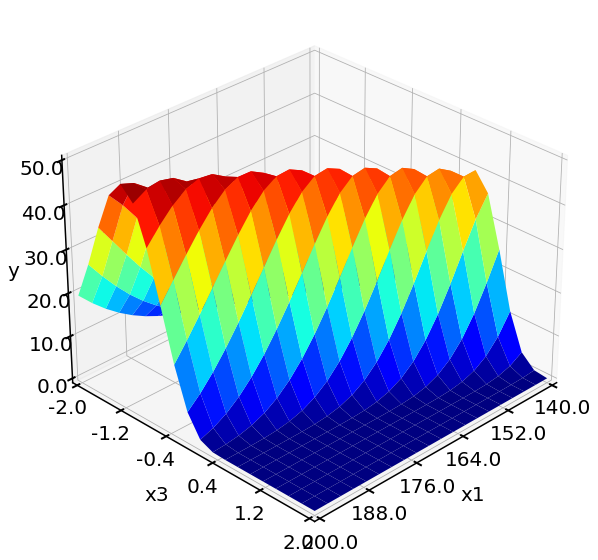

Evaluation of objective function 400 times takes 0.16 min

LHC model surface: 


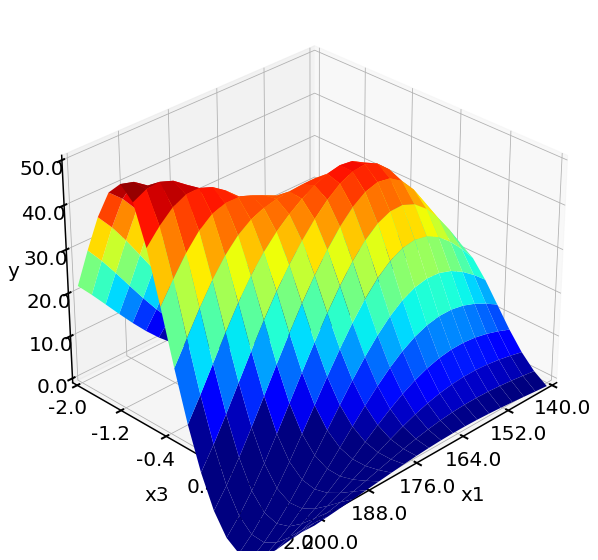

Evaluation of LHC GP model 400 times takes 0.00 min

LHC model surface: 


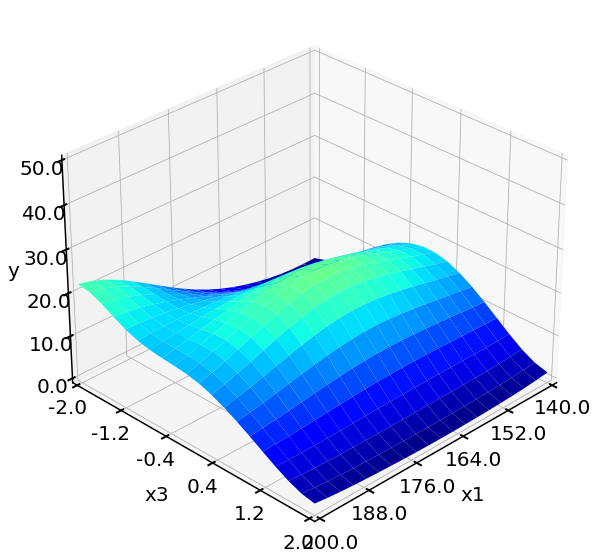

Evaluation of BB GP model 400 times takes 0.00 min

LHC model surface: 


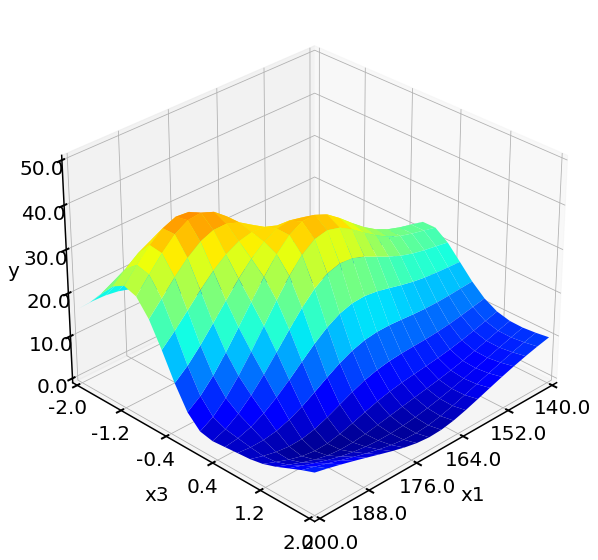

Evaluation of CC GP model 400 times takes 0.00 min

LHC model surface: 


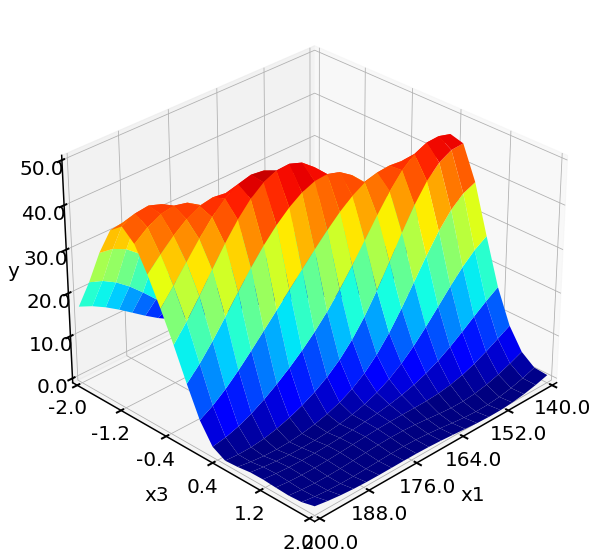

Evaluation of SOBOL GP model 400 times takes 0.00 min



In [55]:
# Suface plots   
# Objective function surface plot  
#(this takes a long time)
print('Objective function surface: ')
start_time = time.time()
plotting.objective_surface(objective_func, 
                          X_ranges, 
                          Y_real_range = Y_plot_range, 
                          x_indices = x_indices, 
                          fixed_values_real = x2_fixed_real, 
                          mesh_size = mesh_size)
end_time = time.time()
print('Evaluation of objective function {} times takes {:.2f} min\n'.format(n_test, (end_time-start_time)/60))


# LHC surface plot
print('LHC model surface: ')
start_time = time.time()
plotting.response_surface_exp(Exp_lhc, 
                              Y_real_range = Y_plot_range,
                              x_indices = x_indices, 
                              fixed_values_real = x2_fixed_real,
                              mesh_size = mesh_size)
end_time = time.time()
print('Evaluation of LHC GP model {} times takes {:.2f} min\n'.format(n_test, (end_time-start_time)/60))

# BB surface plot
print('LHC model surface: ')
start_time = time.time()
plotting.response_surface_exp(Exp_bb, 
                              Y_real_range = Y_plot_range,
                              x_indices = x_indices, 
                              fixed_values_real = x2_fixed_real,
                              mesh_size = mesh_size)
end_time = time.time()
print('Evaluation of BB GP model {} times takes {:.2f} min\n'.format(n_test, (end_time-start_time)/60))

# CC surface plot
print('LHC model surface: ')
start_time = time.time()
plotting.response_surface_exp(Exp_cc, 
                              Y_real_range = Y_plot_range,
                              x_indices = x_indices, 
                              fixed_values_real = x2_fixed_real,
                              mesh_size = mesh_size)
end_time = time.time()
print('Evaluation of CC GP model {} times takes {:.2f} min\n'.format(n_test, (end_time-start_time)/60))

# SOBOL surface plot
print('LHC model surface: ')
start_time = time.time()
plotting.response_surface_exp(Exp_sobol, 
                              Y_real_range = Y_plot_range,
                              x_indices = x_indices, 
                              fixed_values_real = x2_fixed_real,
                              mesh_size = mesh_size)
end_time = time.time()
print('Evaluation of SOBOL GP model {} times takes {:.2f} min\n'.format(n_test, (end_time-start_time)/60))

## 7. Export the optimum

Compare two plans in terms optimum discovered in each trial.

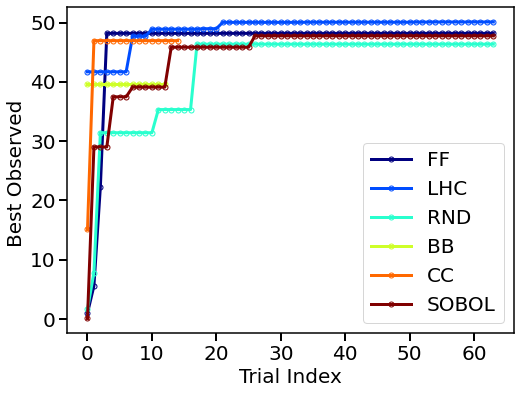

In [56]:
plotting.opt_per_trial([Exp_ff.Y_real, Exp_lhc.Y_real, Exp_rnd.Y_real, Exp_bb.Y_real, Exp_cc.Y_real, Exp_sobol.Y_real], 
                       design_names = ['FF', 'LHC', 'RND', 'BB', 'CC', 'SOBOL'])